In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from PIL import Image

import torch
from torchvision.datasets import LFWPairs
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
# Parametrs
batch = 20
path = "ваш путь"
torch.manual_seed(20)

# если обучение происходит на cpu (чего я крайне не советую :) ), замените
# cuda:0 на cpu
device = torch.device('cuda:0')

Сиамская модель с использованием Contrastive loss

In [ ]:
# подготовка датасета для DataLoader
class PairsTrainDataset(Dataset):
    def __init__(self, path, valid=False):
        if not os.path.exists(f"{path}/lfw-py"):
            self.images = LFWPairs(path, split="train", download=True)
        else:
            self.images = LFWPairs(path, split="train")
        if not valid:
          self.images = [self.images[x] for x in range(800)] + [self.images[x] for x in range(1100, 1900)]
        else:
          self.images = [self.images[x] for x in range(800, 1100)] + [self.images[x] for x in range(1900, 2200)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        X, Y, target = self.images[idx]
        transform=transforms.ToTensor()
        X = transform(X)
        Y = transform(Y)
        return X, Y, target


train_dataset =  PairsTrainDataset(path)
valid_dataset =  PairsTrainDataset(path, valid=True)
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch, shuffle=True)

[1, 2, 6, 7, 8]

In [ ]:

# повторяющийся блок
def block(channels_in, channels_out):
    return nn.Sequential(
        nn.Conv2d(channels_in, channels_out, (3, 3), padding=1),
        nn.Dropout(),
        nn.ReLU(),
    )


class SiameseModel(nn.Module):
  """
  input: пара одинаковых или разных картинок

  return: два эмбеддинга картинок, расстояние между которыми и будем сравнивать
  """
  def __init__(self):
        super().__init__()

        
        self.model1 = nn.Sequential(
            block(3, 64),
            nn.MaxPool2d((2, 2)),
            block(64, 128),
            nn.MaxPool2d((2, 2)),
            block(128, 256),
            block(256, 256),
            block(256, 256),
            nn.Upsample(scale_factor=2),
            block(256, 128),
            nn.Upsample(scale_factor=2),
            block(128, 64),
            nn.Flatten(),
            
        )

        self.model2 = nn.Sequential(
            block(3, 64),
            nn.MaxPool2d((2, 2)),
            block(64, 128),
            nn.MaxPool2d((2, 2)),
            block(128, 256),
            block(256, 256),
            block(256, 256),
            nn.Upsample(scale_factor=2),
            block(256, 128),
            nn.Upsample(scale_factor=2),
            block(128, 64),
            nn.Flatten(), 
        )
        
        self.norm = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
  def forward(self, x1, x2):
        x1 = self.norm(x1)
        x2 = self.norm(x2)
        h1 = self.model1(x1)
        h2 = self.model2(x2)
        return h1, h2


In [ ]:
class ContrasiveLoss(nn.Module):
  """
  Роль константы margin - если расстояние больше, чем margin, то
  лосс не будет меняться. Таким образом мы обращаем больше внимания
  на отрицательные пары, которые ближе, чем margin
  """
  def __init__(self, margin=1):
    super().__init__()
    self.margin = margin
  
  def forward(self, h1, h2, y):
    h = nn.functional.pairwise_distance(h1, h2)
    square = torch.pow(h, 2)
    margin_square = torch.pow(torch.clamp(self.margin - h, min=0.0), 2)
    return torch.mean((y) * square + (1 - y) * margin_square)

In [ ]:
lr = 1e-3

model = SiameseModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = ContrasiveLoss(margin=2)

100%|██████████| 80/80 [02:53<00:00,  2.17s/it]


0: 1.1737881898880005


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


1: 1.2008510828018188


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


2: 0.8855035901069641


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


3: 1.0172861814498901


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


4: 0.9769672751426697


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


5: 1.0264264345169067


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


6: 1.0683077573776245


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


7: 1.0952900648117065


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


8: 0.973082959651947


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


9: 1.073859691619873


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


10: 0.987374484539032


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


11: 0.9661355018615723


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


12: 1.0723894834518433


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


13: 1.0026053190231323


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


14: 1.0157533884048462


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


15: 0.961361825466156


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


16: 1.010750412940979


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


17: 1.0690516233444214


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]


18: 0.9444891214370728


100%|██████████| 80/80 [02:54<00:00,  2.18s/it]

19: 1.143194317817688


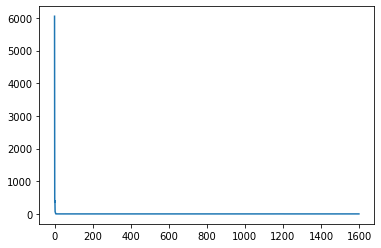

In [ ]:
num_epochs = 20
history = []
for epoch in range(num_epochs):
    for x1, x2, y in tqdm(train_loader):

        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)

        optimizer.zero_grad()

  
        h1, h2 = model(x1, x2)
        loss = criterion(h1, h2, y)

        history.append(loss.item())
        
        loss.backward()

        optimizer.step()
    print(f'{epoch}: {history[-1]}')
plt.plot(np.arange(80*num_epochs), history)

100%|██████████| 30/30 [01:05<00:00,  2.17s/it]


0: 0.9524723887443542


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


1: 1.0065710544586182


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


2: 1.1163185834884644


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


3: 1.117090106010437


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


4: 1.0876935720443726


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


5: 1.0356260538101196


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


6: 0.9467105865478516


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


7: 1.0184296369552612


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]


8: 1.0921348333358765


100%|██████████| 30/30 [01:05<00:00,  2.18s/it]

9: 1.0212241411209106


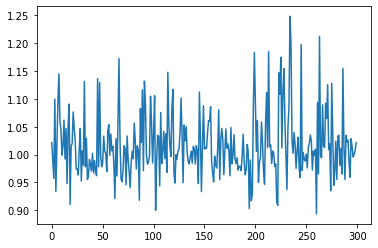

In [ ]:
num_epochs = 10
history = []
for epoch in range(num_epochs):
    for x1, x2, y in tqdm(valid_loader):

        x1 = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)

        optimizer.zero_grad()

  
        h1, h2 = model(x1, x2)
        loss = criterion(h1, h2, y)

        history.append(loss.item())
        
        loss.backward()

        optimizer.step()
    print(f'{epoch}: {history[-1]}')
plt.plot(np.arange(30*num_epochs), history)

0.009102234616875648
0
0.009351426735520363
0
0.009321993216872215
0
0.009269343689084053
0
0.009233478456735611
0
0.009042658843100071
0
0.009155910462141037
0
0.009339369833469391
0
0.009257457219064236
0
0.009184316731989384
0


'END'

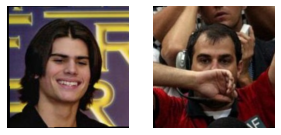

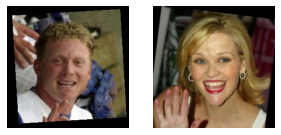

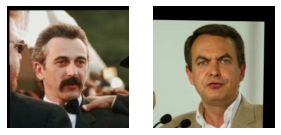

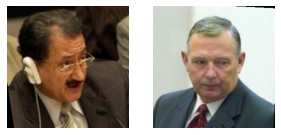

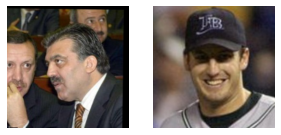

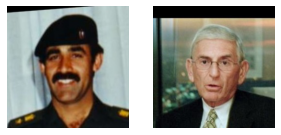

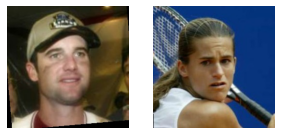

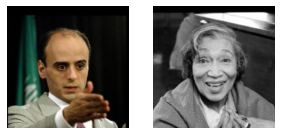

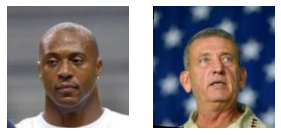

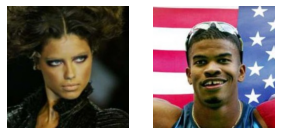

In [ ]:
images = LFWPairs(path, split="test")
tt = transforms.ToTensor()
model.eval()
for i in range(500, 510):
  x1, x2, y = images[i]
  plt.figure(figsize=(10,10))
  plt.subplot(141)
  plt.axis('off')
  plt.imshow(x1)
  plt.subplot(142)
  plt.axis('off')
  plt.imshow(x2)
  x1 = tt(x1)
  x2 = tt(x2)
  h1, h2 = model(x1.to(device).view(1, 3, 250, 250), x2.to(device).view(1, 3, 250, 250))
  h = nn.functional.pairwise_distance(h1, h2)
  print(h.item()), print(y)
model.train()
"END"

Как не трудно заметить, обучение идёт очень быстро (за несколько итераций лосс спадает до 1), однако после этого сеть выходит на плато. На тесте сеть показывает неудовлетворительные результаты, не различая одинаковые и не одинаковые пары. \\
Причины могут быть две: \\
1) Сеть научилась на простых примерах и определяет только их. Плюс сиамская сеть плохо справляется с большин набором данных. \\
2) Сеть просто не обучилась или обучилась неверно. Много раз перепроверенный лосс и последняя по сложности версия CNN почти исключают этот вариант, но он всегда имеет место быть, так что....